# Análise dos dados para obter a resposta em frequêcia de $q(t)$

Precisamos:

- [x] Selecionar o arquivo ulg com os dados,
- [x] Ajustar a janela de recorte de dados,
- [x] Selecionar o arquivo para guardar os dados para o processo de identificação de sistemas

No QGroundControl selecionamos o parâmetro SDLOG_PROFILE para o seguinte:

* Estimator Replay (EKF2)
* System Identification 
* High rate

In [1]:
#import matplotlib
#matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
#matplotlib inline
import numpy as np
import sys
sys.path.append('..')
from myfunctions import read_ulog, list_all_fields, get_ulog_data, butter_lowpass_filter, fft_one_sided, get_euler_angles_from_quat

In [2]:
# Caminho para o arquivo .ulg
file_path = '../ulogs/log_0_2025-4-16-13-19-10.ulg' # square signal Ok! Funciona bem para obter a resposta em frequência. Utilizar essa aqui.
# Ler o arquivo .ulg
ulog = read_ulog(file_path)

In [3]:
# Listar todos os field_data
#list_all_fields(ulog)

## Dados de entrada do experimento

É aplicada à atitude do veículo.

In [4]:
# coletar dados do sinal de entrada
#timestamps_roll, roll   = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'roll_body')
#timestamps_pitch, pitch = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'pitch_body')
#timestamps_yaw, yaw     = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'yaw_body')
timestamps_q0, q0 = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'q_d[0]')
timestamps_q1, q1 = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'q_d[1]')
timestamps_q2, q2 = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'q_d[2]')
timestamps_q3, q3 = get_ulog_data(ulog, 'vehicle_attitude_setpoint', 'q_d[3]')

In [5]:
pitch = get_euler_angles_from_quat(q0, q1, q2, q3, angle='pitch')
timestamps_pitch = timestamps_q0

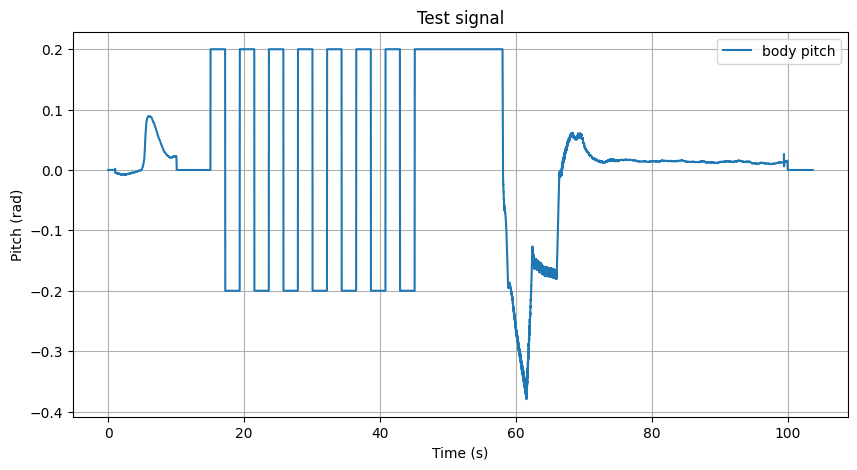

In [6]:
timestamps_pitch_seconds = [(t - timestamps_q0[0]) / 1e0 for t in timestamps_q0]
#
# Gerar os gráficos
plt.figure(figsize=(10, 5))
plt.plot(timestamps_pitch_seconds, pitch, label='body pitch')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (rad)')
plt.title('Test signal')
plt.legend()
plt.grid()
plt.savefig('figures/pitch_signal.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise da FFT para o ângulo Pitch

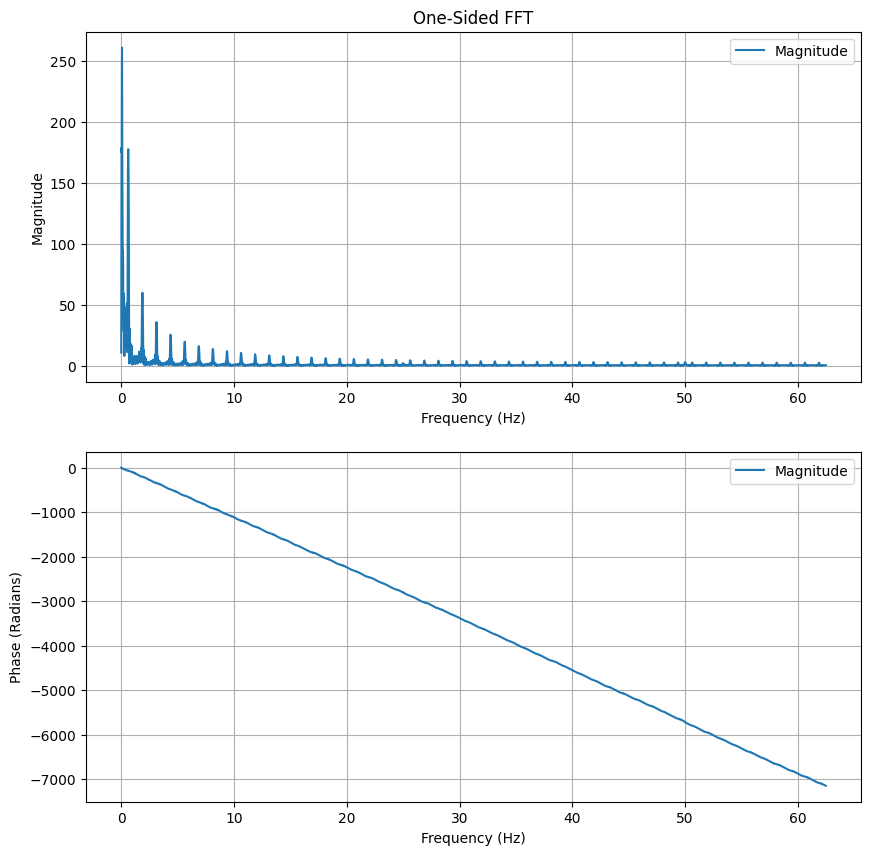

<Figure size 640x480 with 0 Axes>

In [7]:
freq_roll, fft_roll = fft_one_sided(timestamps_pitch, pitch, plot=True, label='Magnitude')
# Salvar a figura gerada pela função fft_one_sided
plt.savefig('figures/fft_pitch_signal.png', dpi=300, bbox_inches='tight')
plt.show()

## Sinais dos motores e das taxas
Gerados indiretamente por meio da atitude desejada.

In [8]:
# Coletar os dados dos atuadores
timestamps_c0, control0 = get_ulog_data(ulog, 'actuator_motors', 'control[0]')
timestamps_c1, control1 = get_ulog_data(ulog, 'actuator_motors', 'control[1]')
timestamps_c2, control2 = get_ulog_data(ulog, 'actuator_motors', 'control[2]')
timestamps_c3, control3 = get_ulog_data(ulog, 'actuator_motors', 'control[3]')

In [9]:
# Coletar os dados das taxas de rotação
timestamps_vav0, vav0 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[0]')
timestamps_vav1, vav1 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[1]')
timestamps_vav2, vav2 = get_ulog_data(ulog, 'vehicle_angular_velocity', 'xyz[2]')

In [10]:
# 
dt_controle = timestamps_c0[1] - timestamps_c0[0]  # Período de amostragem dos dados
t_controle = np.linspace(0, len(control0)*dt_controle, len(control0))  # Vetor de tempo
#
dt_taxas = timestamps_vav1[1] - timestamps_vav1[0]  # Período de amostragem dos dados
t_taxas = np.linspace(0, len(vav1)*dt_taxas, len(vav1))  # Vetor de tempo

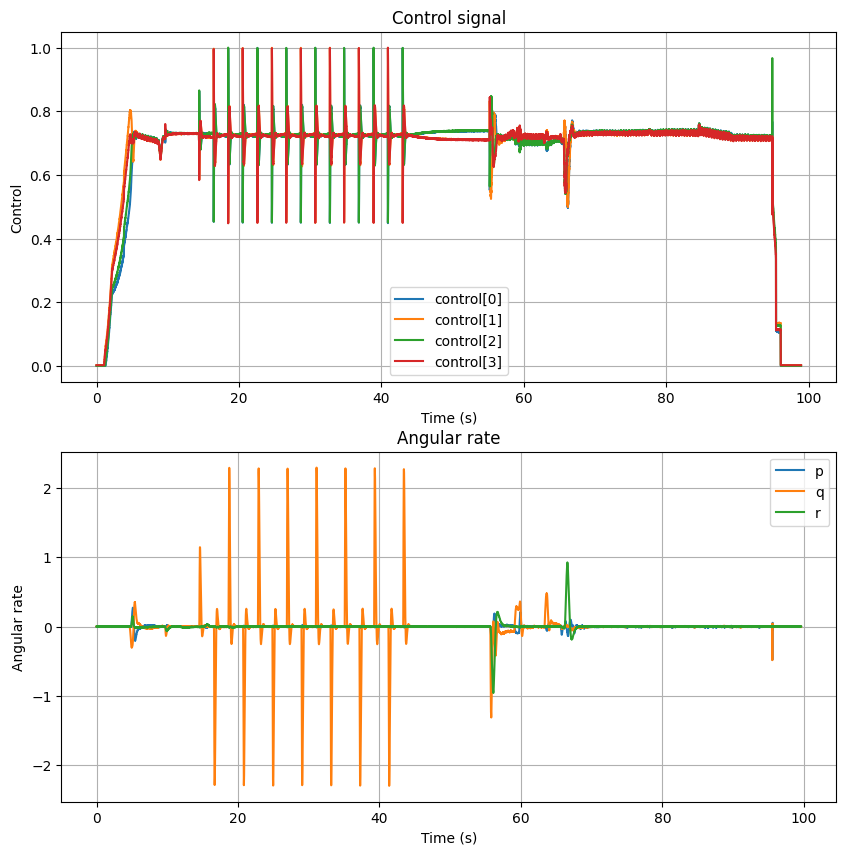

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
#
ax1.plot(t_controle, control0, label='control[0]')
ax1.plot(t_controle, control1, label='control[1]')
ax1.plot(t_controle, control2, label='control[2]')
ax1.plot(t_controle, control3, label='control[3]')
#
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Control')
ax1.set_title('Control signal')
ax1.legend()
ax1.grid()
#
ax2.plot(t_taxas, vav0, label='p')
ax2.plot(t_taxas, vav1, label='q')
ax2.plot(t_taxas, vav2, label='r')
#
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angular rate')
ax2.set_title('Angular rate')
ax2.legend()
ax2.grid()
#
#plt.tight_layout()
plt.show()
#  

## Recorte de sinais e ajuste do sinal de controle

* O sinal de controle é obtido da seguinte forma `'control[1] + control[2] - control[0] - control[3]'`.
* É tirada a média dos sinais de controle.
* Os sinais de controle e de taxa 'p' são filtrados com um filtro pasa baixas Butterworth de ordem 5.

In [12]:
# Recortando os dados para análise
t0_clip = 12.0
t1_clip = 45.0 #t0_clip + 15.0
#
t_cont_clipped = t_controle[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - t0_clip   # Recortando o vetor de tempo
controle0_clipped = control0[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control0[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
controle1_clipped = control1[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control1[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
controle2_clipped = control2[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control2[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
controle3_clipped = control3[(t_controle >= t0_clip) & (t_controle <= t1_clip)] - np.mean(control3[(t_controle >= t0_clip) & (t_controle <= t1_clip)]) # Recortando o vetor de controle
# 
controle_clipped = controle1_clipped + controle2_clipped - controle0_clipped - controle3_clipped
# recortando as taxas de rotação
t_taxas_clipped = t_taxas[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)] - t0_clip   # Recortando o vetor de tempo
vav0_clipped = vav0[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação
vav1_clipped = vav1[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação
vav2_clipped = vav2[(t_taxas >= t0_clip) & (t_taxas <= t1_clip)]  # Recortando as taxas de rotação

## Filtrando os dados

In [13]:
# Filtrando os sinais
cutoff_freq = 20.0 # Hz
controle0_clipped_filt = butter_lowpass_filter(controle0_clipped, cutoff_freq, 1/dt_controle, order=5)
controle1_clipped_filt = butter_lowpass_filter(controle1_clipped, cutoff_freq, 1/dt_controle, order=5)
controle2_clipped_filt = butter_lowpass_filter(controle2_clipped, cutoff_freq, 1/dt_controle, order=5)
controle3_clipped_filt = butter_lowpass_filter(controle3_clipped, cutoff_freq, 1/dt_controle, order=5)
#
controle_clipped_filtered =+ controle1_clipped_filt - controle2_clipped_filt - controle0_clipped_filt + controle3_clipped_filt
#
vav1_clipped_filtered = butter_lowpass_filter(vav1_clipped, cutoff_freq, 1/dt_taxas, order=5)    

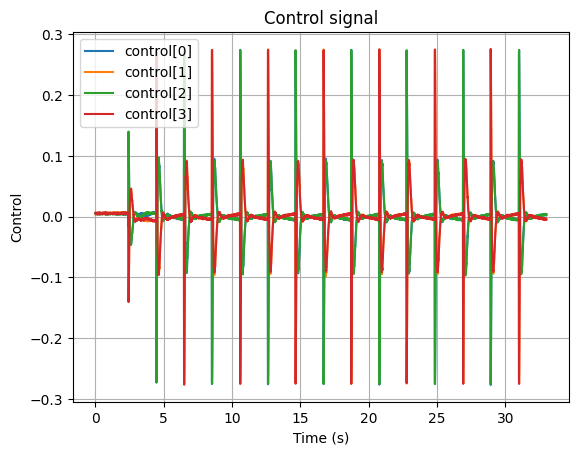

In [14]:
# Plotando os dados recortados
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)  # Cria um único subplot na figura

#
ax1.plot(t_cont_clipped, controle0_clipped, label='control[0]')
ax1.plot(t_cont_clipped, controle1_clipped, label='control[1]')
ax1.plot(t_cont_clipped, controle2_clipped, label='control[2]')
ax1.plot(t_cont_clipped, controle3_clipped, label='control[3]')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Control')
ax1.set_title('Control signal')
ax1.legend()
#ax1.set_ylim(-0.001, 0.001)
ax1.grid()
plt.show()

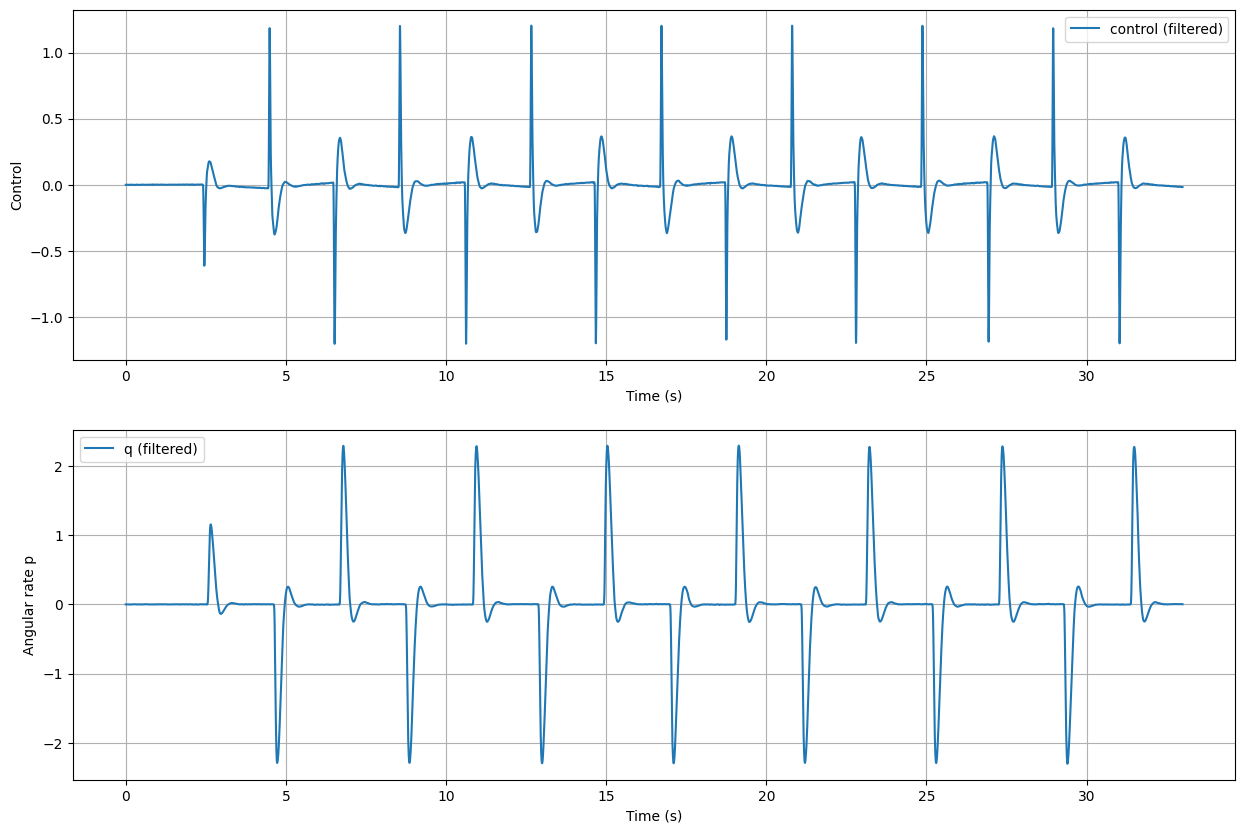

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
#
ax1.plot(t_cont_clipped, controle_clipped_filtered, label='control (filtered)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Control')
ax1.legend()
ax1.grid()
#
#ax2.plot(t_taxas_clipped, vav0_clipped, label='p')
ax2.plot(t_taxas_clipped, vav1_clipped_filtered, label='q (filtered)')
#ax3.plot(t_taxas_clipped, vav1_clipped, label='q')
#ax3.plot(t_taxas_clipped, vav2_clipped, label='r')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angular rate p')
#ax2.set_title('Velocidade angular ao longo do tempo')
ax2.legend()
ax2.grid()  
#
#plt.tight_layout()
plt.savefig('figures/control_q_rate_signals.png', dpi=300, bbox_inches='tight')
plt.show()

## Fast-Fourier Transform
É obtida a Transformada de Fourier unidirecional dos sinais.

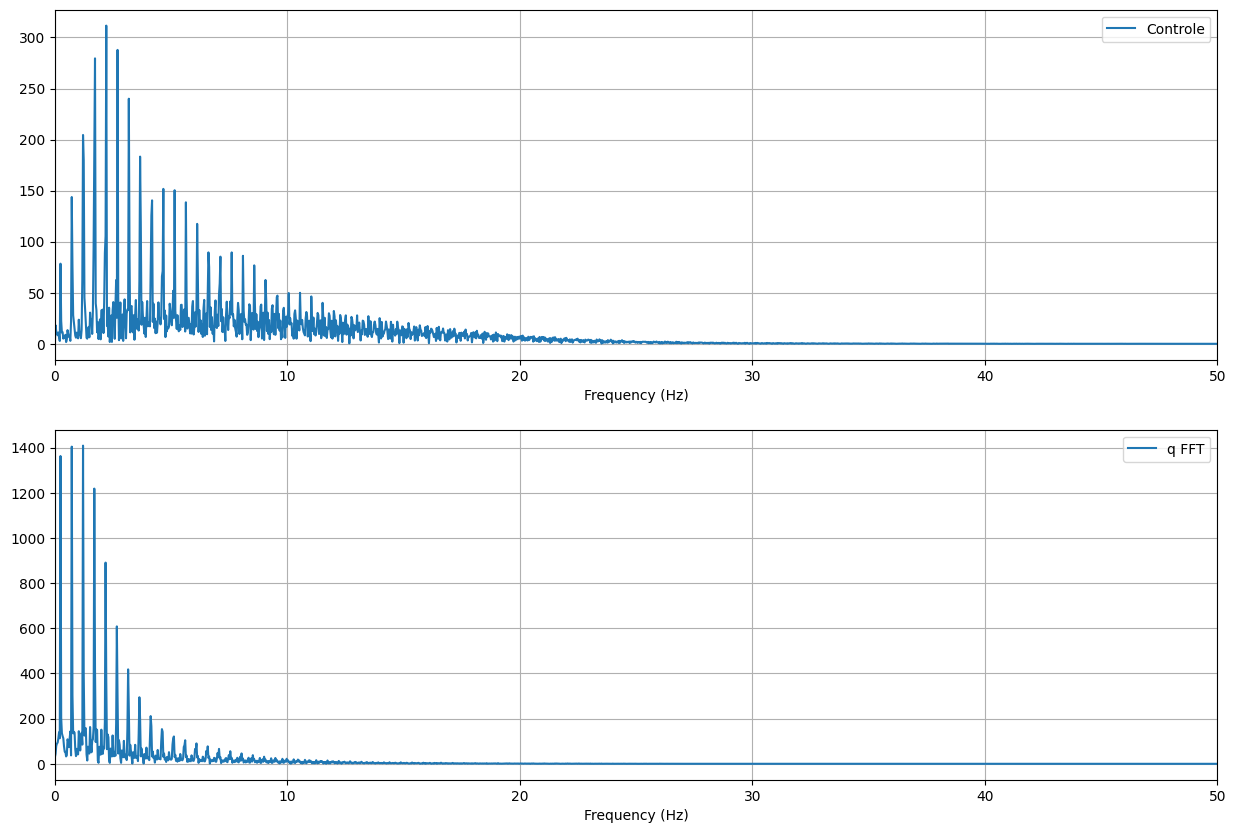

In [16]:
# One-side FFT de controle_clipped
fft_controle = np.fft.fft(controle_clipped_filtered)
freq = np.fft.fftfreq(len(controle_clipped_filtered), dt_controle)
fft_controle_one_sided = fft_controle[:len(fft_controle)//2]
freq_one_sided = freq[:len(freq)//2]

# One-side FFT de vav0_clipped
fft_vav1 = np.fft.fft(vav1_clipped_filtered)
freq_vav1 = np.fft.fftfreq(len(vav1_clipped_filtered), dt_taxas)
fft_vav1_one_sided = fft_vav1[:len(fft_vav1)//2]
freq_vav1_one_sided = freq_vav1[:len(freq_vav1)//2]
#
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(freq_one_sided, np.abs(fft_controle_one_sided), label='Control FFT')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_xlim(0, 50)
ax1.legend()
#ax1.set_title('Control FFT ')
ax1.grid()
ax1.legend(['Controle', 'Angular rate q'])

ax2.plot(freq_vav1_one_sided, np.abs(fft_vav1_one_sided), label='q FFT')
ax2.set_xlim(0, 50)
ax2.legend()
ax2.grid()
ax2.set_xlabel('Frequency (Hz)')

plt.savefig('figures/control_q_rate_FFT.png', dpi=300, bbox_inches='tight')
plt.show()

## Resposta em frequência
É obtida a resposta em freqência.

In [17]:
# calculate the magnitude of the FFT data
modulo = 20*np.log10(np.abs(fft_vav1_one_sided)/np.abs(fft_controle_one_sided))
# Calculate the phase angle of the FFT data
phase_controle = np.unwrap(np.angle(fft_controle_one_sided))
phase_vav1 = np.unwrap(np.angle(fft_vav1_one_sided))
fase = np.unwrap(phase_vav1 - phase_controle)

In [18]:
# clipping dos dados
f_hz_clipping = 10 # hz
#
freq_rad_s_clipped = (freq_one_sided[(freq_one_sided >= 0) & (freq_one_sided <= f_hz_clipping)])*2*np.pi 
modulo_dB_clipped = modulo[(freq_one_sided >= 0) & (freq_one_sided <= f_hz_clipping)]
fase_deg_clipped = np.unwrap(np.mod((fase[(freq_one_sided >= 0) & (freq_one_sided <= f_hz_clipping)])*180/np.pi,-360))

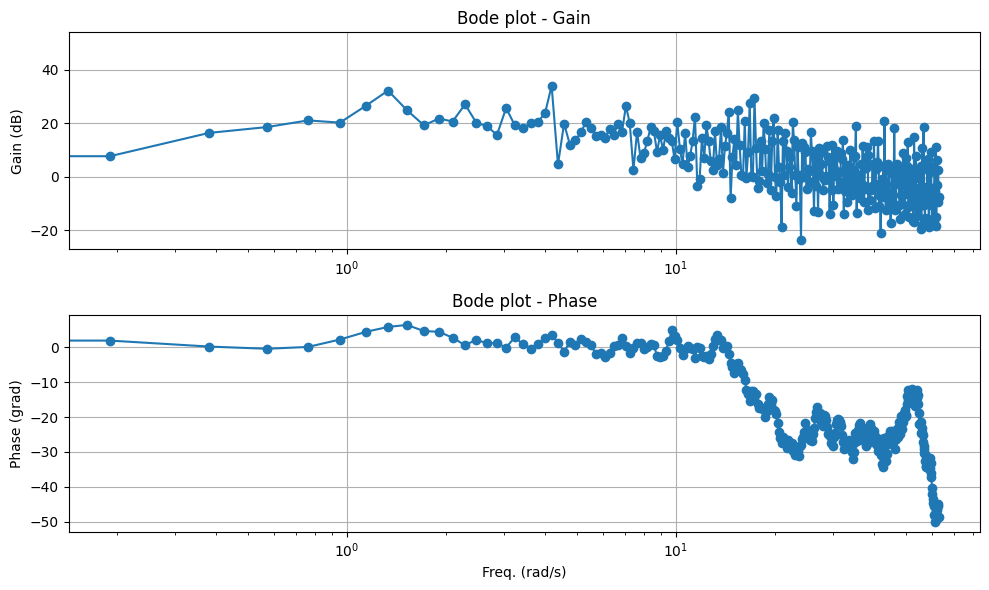

In [19]:
# Diagrama de Bode
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.semilogx(freq_rad_s_clipped, modulo_dB_clipped,'-o')
#ax1.set_ylim([0, 60])
ax1.set_ylabel('Gain (dB)')
ax1.set_title('Bode plot - Gain')
ax1.grid()
ax2.semilogx(freq_rad_s_clipped, fase_deg_clipped, 'o-')
#ax2.set_ylim([-175, -80])
ax2.set_xlabel('Freq. (rad/s)')
ax2.set_ylabel('Phase (grad)')
ax2.set_title('Bode plot - Phase')
ax2.grid()
#ax2.set_ylim([-360, 0])
plt.savefig('figures/bode_q_rate.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

plt.show()

## Guarda os dados para análise posterior

In [20]:
# salvar os dados
# as frequencias, o modulo e a fase

np.savetxt('dados/freq_rad_s_q_rate.txt', freq_rad_s_clipped)
np.savetxt('dados/modulo_dB_q_rate.txt', modulo_dB_clipped)
np.savetxt('dados/fase_deg_q_rate.txt', fase_deg_clipped)


In [21]:
# salvar os dados t_cont_clipped, controle_clipped_filtered, vav0_clipped_filtered
"""
np.savetxt('dados/t_controle.txt', t_cont_clipped)
np.savetxt('dados/controle.txt', controle_clipped_filtered)
np.savetxt('dados/vav1.txt', vav1_clipped_filtered)
"""

"\nnp.savetxt('dados/t_controle.txt', t_cont_clipped)\nnp.savetxt('dados/controle.txt', controle_clipped_filtered)\nnp.savetxt('dados/vav1.txt', vav1_clipped_filtered)\n"